# Tidymodels: tidy machine learning in R
Rebecca Barter (@rlbarter)

### Resources: 
Tidy Modeling with R book (https://www.tmwr.org/) by Max Kuhn and Julia Silge

My blog post (http://www.rebeccabarter.com/blog/2020-03-25_machine_learning/)

# Introducing the data

In [1]:
library(tidyverse)
library(mlbench)
data(PimaIndiansDiabetes)
diabetes_orig <- PimaIndiansDiabetes

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
head(diabetes_orig)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,0,33.6,0.627,50,pos
2,1,85,66,29,0,26.6,0.351,31,neg
3,8,183,64,0,0,23.3,0.672,32,pos
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
6,5,116,74,0,0,25.6,0.201,30,neg


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



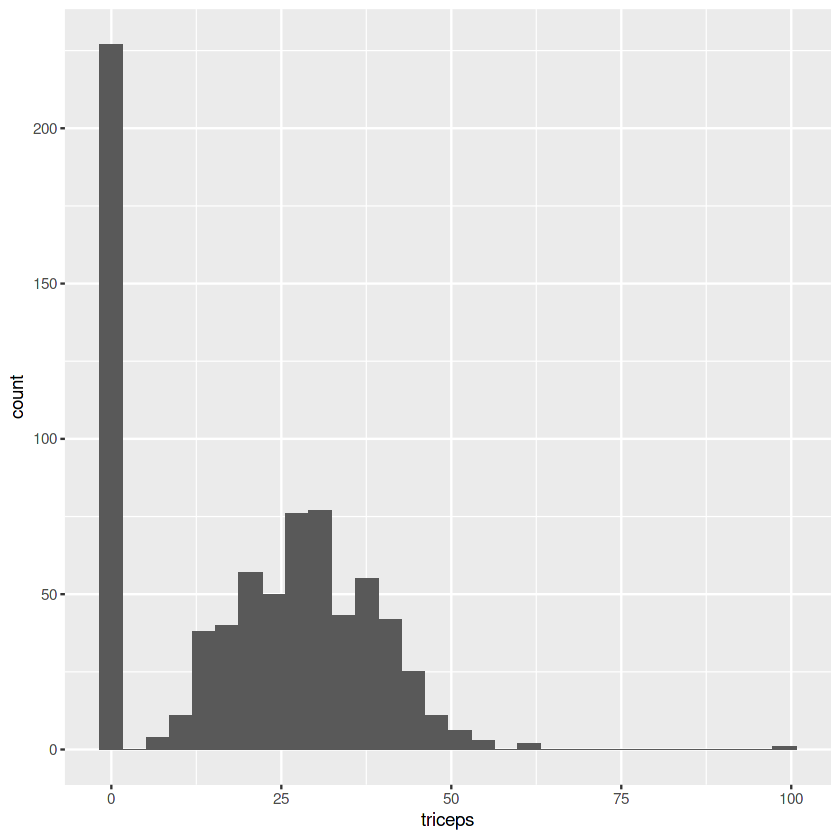

In [3]:
ggplot(diabetes_orig) +
  geom_histogram(aes(x = triceps))

In [4]:
# replace 0s with NA
diabetes_clean <- diabetes_orig %>%
  mutate_at(vars(triceps, glucose, pressure, insulin, mass), 
            ~na_if(., 0)) %>%
# add a numeric version of the variable
  mutate(diabetes_numeric = if_else(diabetes == "pos", 1, 0))

In [5]:
head(diabetes_clean)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes,diabetes_numeric
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,6,148,72,35,NA,33.6,0.627,50,pos,1
2,1,85,66,29,NA,26.6,0.351,31,neg,0
3,8,183,64,NA,NA,23.3,0.672,32,pos,1
4,1,89,66,23,94,28.1,0.167,21,neg,0
5,0,137,40,35,168,43.1,2.288,33,pos,1
6,5,116,74,NA,NA,25.6,0.201,30,neg,0


# Why tidymodels?

Let's say we want to fit several models:

In [6]:
library(glmnet)
library(randomForest)
library(ranger)
library(e1071)
library(bnstruct, lib.loc = "MyRlibs")

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.0

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following object is masked from ‘package:ggplot2’:

    margin



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance


Loading required package: bitops

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The following object is masked from ‘package:tibble’:

    as_data_frame


The following objects are masked from ‘package:stats’:

    d

First, I'd have to do some imputation preparation

In [7]:
# create numeric matrix
diabetes_numeric_matrix <- diabetes_clean %>% 
  select_if(is.numeric) %>%
  as.matrix

Then I'd have to actually impute them and do some annoying conversions

In [8]:
# impute numeric matrix
diabetes_imputed <- knn.impute(diabetes_numeric_matrix, 
                               k = 10) %>%
  # convert back to tibble
  as_tibble %>%
  # add diabetes factor variable back in
  mutate(diabetes = diabetes_clean$diabetes)
head(diabetes_imputed)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes_numeric,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,130,33.6,0.627,50,1,pos
1,85,66,29,196,26.6,0.351,31,0,neg
8,183,64,30,495,23.3,0.672,32,1,pos
1,89,66,23,94,28.1,0.167,21,0,neg
0,137,40,35,168,43.1,2.288,33,1,pos
5,116,74,21,23,25.6,0.201,30,0,neg


Logistic regression:

In [ ]:
glm(diabetes ~ pregnant + glucose, 
    data = diabetes_imputed, 
    family = "binomial")

Penalized logistic regression:

In [ ]:
glmnet(x = as.matrix(diabetes_imputed[, c("pregnant", "glucose")]), 
       y = diabetes_imputed$diabetes, 
       family = "binomial",
       alpha = 1)

Random forest:

In [ ]:
randomForest(x = diabetes_imputed[, c("pregnant", "glucose")], 
             y = diabetes_imputed$diabetes)

A different implementation of random forest:

In [ ]:
ranger(diabetes ~ pregnant + glucose, 
       data = diabetes_imputed)

SVM

In [ ]:
svm(x = diabetes_imputed[, c("pregnant", "glucose")], 
    y = diabetes_imputed$diabetes)

## Tidymodels

Tidymodels gives us a consistent way to:

1. Split into train/test set

1. Define a recipe for pre-processing

1. Specify the model

1. Tune the parameters

1. Evaluate and compare models

1. Generate predictions using your final model

1. Variable importance 

Just like the tidyverse, you can load everything with just one package:

In [9]:
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 0.1.2 ──

✔ broom     0.7.5      ✔ recipes   0.1.15
✔ dials     0.0.9      ✔ rsample   0.0.9 
✔ infer     0.5.4      ✔ tune      0.1.2 
✔ modeldata 0.1.0      ✔ workflows 0.2.1 
✔ parsnip   0.1.5      ✔ yardstick 0.0.7 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ igraph::as_data_frame() masks dplyr::as_data_frame(), tibble::as_data_frame()
✖ broom::bootstrap()      masks bnstruct::bootstrap()
✖ randomForest::combine() masks dplyr::combine()
✖ bnstruct::complete()    masks tidyr::complete()
✖ igraph::compose()       masks purrr::compose()
✖ igraph::crossing()      masks tidyr::crossing()
✖ dials::degree()         masks igraph::degree()
✖ scales::discard()       masks purrr::discard()
✖ Matrix::expand()        masks tidyr::expand()
✖ dplyr::filter()         masks stats::filter()
✖ recipes::fixed()        masks stringr::fixed()
✖ igraph::groups()        masks dplyr::groups()
✖ d

# Where we're heading: the final workflow

In [ ]:
# set the workflow
rf_workflow <- workflow() %>%
  # add the recipe
  add_recipe(diabetes_recipe) %>%
  # add the model
  add_model(rf_model)

In [ ]:
# fit the workflow model
final_model <- fit(rf_workflow, diabetes_clean)

In [ ]:
# use the fitted model for prediction
predict(final_model, new_data = new_diabetes_data)

# Splitting into train/test

In [10]:
set.seed(234589)
# split the data into trainng (75%) and testing (25%)
diabetes_split <- initial_split(diabetes_clean, prop = 0.7)

In [11]:
diabetes_split

<Analysis/Assess/Total>
<538/230/768>

## Extracting the training and test sets

In [12]:
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

In [13]:
dim(diabetes_train)

[1] 538  10

In [14]:
dim(diabetes_test)

[1] 230  10

# Define a recipe

In [15]:
# define the recipe
diabetes_recipe <- 
  # which consists of the formula (outcome ~ predictors)
  recipe(diabetes ~ pregnant + glucose + pressure + triceps + 
           insulin + mass + pedigree + age, 
         data = diabetes_clean) %>%
  # and some pre-processing steps
  step_normalize(all_numeric()) %>%
  step_knnimpute(all_predictors())

In [16]:
diabetes_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          8

Operations:

Centering and scaling for all_numeric()
K-nearest neighbor imputation for all_predictors()

Note: We used `data = diabetes_clean` here. Why not `data = diabetes_train`? Does it matter?

Hint: This is setting up for pre-processing but hasn't performed the pre-processing yet!

## OPTIONAL: Applying the recipe

You need to "prep" the recipe on a dataset before baking with it!

In [17]:
diabetes_recipe_prepped <- diabetes_recipe %>%
  prep(diabetes_train)

In [18]:
diabetes_preprocessed_train <- bake(diabetes_recipe_prepped, new_data = NULL)

In [19]:
head(diabetes_preprocessed_train)

pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.6670982,0.8324250,-0.04685081,0.62683387,0.37213110,0.1921970,0.5624373,1.3498127,pos
-0.8122869,-1.2237776,-0.52463625,0.04715349,-0.96455284,-0.8228586,-0.3541839,-0.2193657,neg
1.2588522,1.9747598,-0.68389806,0.35631636,1.16056578,-1.3013848,0.7118863,-0.1367773,pos
-1.1081640,0.4734055,-2.59503983,0.62683387,0.08321244,1.5697723,6.0787694,-0.0541890,pos
0.3712212,-0.2119954,0.11241101,-0.68710833,-0.41630357,-0.9678665,-0.8523475,-0.3019540,neg
-0.5164099,2.4316937,-0.20611262,1.59296784,3.34660098,-0.2573276,-0.9951544,1.5975777,pos


In [20]:
diabetes_preprocessed_test <- bake(diabetes_recipe_prepped, new_data = diabetes_test)

In [21]:
head(diabetes_test)

,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes,diabetes_numeric
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
4,1,89,66,23,94,28.1,0.167,21,neg,0
7,3,78,50,32,88,31.0,0.248,26,pos,1
8,10,115,NA,NA,NA,35.3,0.134,29,neg,0
12,10,168,74,NA,NA,38.0,0.537,34,pos,1
19,1,103,30,38,83,43.3,0.183,33,neg,0
21,3,126,88,41,235,39.3,0.704,27,neg,0


# Summary so far

Recall that we're heading towards

In [22]:
# set the workflow
rf_workflow <- workflow() %>%
  # add the recipe
  add_recipe(diabetes_recipe) %>%
  # add the model
  add_model(rf_model)

ERROR: Error in is_model_spec(spec): object 'rf_model' not found


We still need to define a model!

# Specify a model

You need to specify:
1. The model type
1. The arguments/parameters
1. The "engine" (e.g. package)
1. The "mode" (classification or regression?)

In [23]:
rf_model <- 
  # model type
  rand_forest() %>%
  # arguments
  set_args(mtry = 4) %>%
  # engine/package that underlies the model
  set_engine("ranger", importance = "impurity") %>%
  # mode
  set_mode("classification") 

In [24]:
# logistic regression:
lr_model <- 
  # specify that the model is a logistic_reg
  logistic_reg() %>%
  # select the engine/package that underlies the model
  set_engine("glm") %>%
  # choose either the continuous regression or binary classification mode
  set_mode("classification") 

# Workflows: combining recipes and models

In [26]:
# set the workflow
rf_workflow <- workflow() %>%
  # add the recipe
  add_recipe(diabetes_recipe) %>%
  # add the model
  add_model(rf_model)

In [27]:
rf_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_normalize()
● step_knnimpute()

── Model ───────────────────────────────────────────────────────────────────────
Random Forest Model Specification (classification)

Main Arguments:
  mtry = 4

Engine-Specific Arguments:
  importance = impurity

Computational engine: ranger 


Fit the model:

In [28]:
rf_fit <- fit(rf_workflow, diabetes_train) 
# note: this will run prep(diabetes_recipe, diabetes_train)

In [29]:
rf_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: rand_forest()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_normalize()
● step_knnimpute()

── Model ───────────────────────────────────────────────────────────────────────
Ranger result

Call:
 ranger::ranger(x = maybe_data_frame(x), y = y, mtry = min_cols(~4,      x), importance = ~"impurity", num.threads = 1, verbose = FALSE,      seed = sample.int(10^5, 1), probability = TRUE) 

Type:                             Probability estimation 
Number of trees:                  500 
Sample size:                      538 
Number of independent variables:  8 
Mtry:                             4 
Target node size:                 10 
Variable importance mode:         impurity 
Splitrule:                        gini 
OOB prediction error (Brier s.):  0.1589301 

# Recap

In [30]:
set.seed(234589)
# split the data into trainng (75%) and testing (25%)
diabetes_split <- initial_split(diabetes_clean, prop = 0.7)

In [31]:
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

In [32]:
# define the recipe
diabetes_recipe <- 
  # which consists of the formula (outcome ~ predictors)
  recipe(diabetes ~ pregnant + glucose + pressure + triceps + 
           insulin + mass + pedigree + age, 
         data = diabetes_clean) %>%
  # and some pre-processing steps
  step_normalize(all_numeric()) %>%
  step_knnimpute(all_predictors())

In [ ]:
rf_model <- 
  # specify that the model is a random forest
  rand_forest() %>%
  # specify the `mtry` argument
  set_args(mtry = 4) %>%
  # select the engine/package that underlies the model
  set_engine("ranger", importance = "impurity") %>%
  # choose either the continuous regression or binary classification mode
  set_mode("classification") 

In [ ]:
# set the workflow
rf_workflow <- workflow() %>%
  # add the recipe
  add_recipe(diabetes_recipe) %>%
  # add the model
  add_model(rf_model)

In [33]:
rf_fit <- fit(rf_workflow, diabetes_train)

# Predict on the test set

In [34]:
# evaluate on test set
diabetes_test_pred <- predict(rf_fit, diabetes_test)
head(diabetes_test_pred)


.pred_class
<fct>
neg
neg
neg
pos
neg
neg


In [35]:
diabetes_test_pred <- diabetes_test_pred %>%
  transmute(pred = .pred_class,
            truth = diabetes_test$diabetes)
head(diabetes_test_pred)

pred,truth
<fct>,<fct>
neg,neg
neg,pos
neg,neg
pos,pos
neg,neg
neg,neg


Calculate metrics

In [36]:
diabetes_test_pred %>%
  accuracy(pred, truth)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7521739


In [37]:
diabetes_test_pred %>%
  spec(pred, truth)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
spec,binary,0.6875
